In [12]:
from influxdb import InfluxDBClient
import config_sandbox
from datetime import datetime, timedelta
import pytz
import pandas as pd

In [13]:
sandbox_client = InfluxDBClient(
    host=config_sandbox.HOST,
    port=config_sandbox.PORT,
    username=config_sandbox.USERNAME,
    password=config_sandbox.PASSWORD,
    database=config_sandbox.DATABASE
)

sandbox_query = sandbox_client.query
time_range = {"from": "2026-02-01 00:00:00","to": "2026-02-1 20:00:00"}
group_by_time = "1s"

In [14]:
def get_measurement(query_api, start_time: str = "", end_time: str = "", designator: str = "", aggregator: str = "*", group_by_time: str = "1s", vin: str = "Sandbox1"):
    # convert grafana time format to datetime, bake in timezone
    start_date = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S').astimezone(pytz.timezone("US/Pacific"))
    end_date = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S').astimezone(pytz.timezone("US/Pacific"))
    now = datetime.now(pytz.timezone("US/Pacific"))

    # more timezone stuff
    start_utc = start_date.astimezone(pytz.utc)
    end_utc = end_date.astimezone(pytz.utc)

    # check if policy needs to be tenyear or autogen
    if (now - start_date) > timedelta(weeks=2) or (now - end_date) > timedelta(weeks=2):
        policy = 'tenyear'
    else:
        policy = 'autogen'

    # convert utc timezone to string for querying
    start = start_utc.strftime("%Y-%m-%dT%H:%M:%SZ")
    end = end_utc.strftime("%Y-%m-%dT%H:%M:%SZ")

    agg_verbose = ''
    group_by_verbose = ''
    group_by_str = ''
    if aggregator != '*':
        agg_verbose = f' {aggregator}'
        group_by_verbose = f', aggregated every {group_by_time}'
        group_by_str = f'GROUP BY time({group_by_time}) fill(null)'
        
        aggregator = f' {aggregator}("value")'

    print(f"Getting{agg_verbose} '{designator}' data from {start} to {end} with {policy} policy{group_by_verbose}")

    # # calculated data are queried and retrieved differently than data from sensors, also VC is different as well
    # if len(designator.split('/')) == 2 and vin != 'VC1': # calculated stuff
    #     query = f'SELECT * FROM "{policy}"."/{designator}" WHERE time > \'{start}\' AND time < \'{end}\''
    #     resultSet = query_api(query).get_points(tags={'designator': '-'})
    # elif len(designator.split('/')) == 1: # IO list stuff
    #     query = f'SELECT {aggregator} FROM "{policy}"."/IOList/{designator}/Value" WHERE time > \'{start}\' AND time < \'{end}\' {group_by_str}'
    #     resultSet = query_api(query).get_points(tags={'designator': f'{designator}'}) if aggregator == '*' else query_api(query).get_points()
    # else: # VC stuff
    #     query = f'SELECT {aggregator} FROM "{policy}"."{designator}" WHERE ("vin"=\'{vin}\') AND time > \'{start}\' AND time < \'{end}\' {group_by_str}'
    #     resultSet = query_api(query).get_points(tags={'designator': 'NA'}) if aggregator == '*' else query_api(query).get_points()

    query = f'SELECT {aggregator} FROM "{policy}"."/IOList/{designator}/Value" WHERE time > \'{start}\' AND time < \'{end}\' {group_by_str}'
    resultSet = query_api(query).get_points(tags={'designator': f'{designator}'}) if aggregator == '*' else query_api(query).get_points()

    return list(resultSet)

Getting mean 'R1_LEFT_ANGLE' data from 2026-02-01T06:00:00Z to 2026-02-02T02:00:00Z with autogen policy, aggregated every 1s


<Axes: >

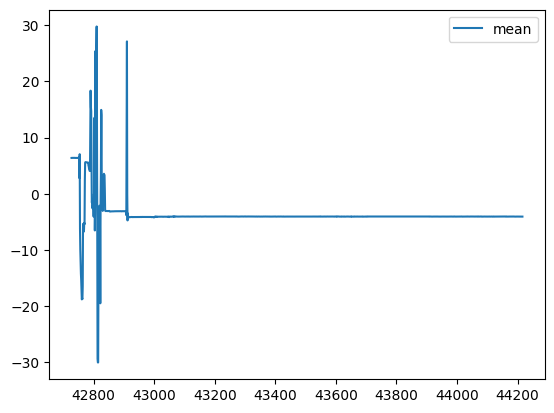

In [17]:
data = get_measurement(query_api=sandbox_query, start_time=time_range["from"], end_time=time_range["to"], designator="R1_LEFT_ANGLE", aggregator="mean", group_by_time=group_by_time, vin="Sandbox1")
df_data = pd.DataFrame(data)
df_data.plot()